In [289]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# lightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers

print(tf.__version__)


warnings.filterwarnings("ignore", category=UserWarning) 

training_file = '../training_processed.csv'
testing_file = '../智能制造赛道测试集/test/testing.csv'

2.9.2


## 01 - loading and preprocess data

In [301]:
# load training & testing file
training = pd.read_csv(training_file, low_memory=False)
testing = pd.read_csv(testing_file, low_memory=False)

# from previous notebook we know that some feature have high correlation 

# grate_manual_command <-> grate_actual_operation_command = 1
# primary_air_volume <-> induced_fan_speed = 0.85
# primary_air_volume <-> primary_damper = 0.84
# ejector_manual_command <-> ejector_automatic_command = 0.82
# secondary_air_control_door <-> secondary_air_volume = 0.99

numerical_features = [
                      'oxygen_set_value', # '氧量设定值'
                      'primary_air_volume', # '一次风量'
                      # 'grate_manual_command',  #  '炉排手动指令'
                      'main_steam_flow_set_value', # '主蒸汽流量设定值'
                      'ejector_manual_command', #  '推料器手动指令'
                      'ejector_automatic_command', # '推料器自动指令'
                      'nox_content', # NOx含量
                      'grate_actual_operation_command', # 炉排实际运行指令
                      'secondary_air_control_door', # 二次风调门
                      'hcl_content', # HCL含量
                      'secondary_air_volume', # 二次风量
                      'water_flow', # 给水流量
                      'so2_content', # SO2含量
                      'drum_water_level', # 汽包水位
                      'induced_fan_speed', # 引风机转速
                      'co_content', # CO含量
                      'primary_damper' # 一次风调门
                      ] 

categorical_features = ['ejector_automatic_switching_signal', # '推料器自动投退信号'
                        'grate_automatic_switching_signal', # '炉排自动投退信号'
                        'pusher_on_or_off', # 推料器启停
                        'grate_on_or_off'] # 炉排启停

training.drop(columns=['mod', 'hod', 'sod', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'sec_sin', 'sec_cos'], inplace=True)

label = ['main_steam_flow']

In [302]:
training.head(1)

datetime  oxygen_set_value  primary_air_volume  \
0  2021-12-20 00:00:00               5.5          72919.6563   

   ejector_automatic_switching_signal  grate_automatic_switching_signal  \
0                                True                              True   

   grate_manual_command  main_steam_flow_set_value  ejector_manual_command  \
0               43.9083                       60.0                 53.9083   

   ejector_automatic_command  nox_content  ...  secondary_air_volume  \
0                    53.9094      57.4444  ...              4330.127   

   water_flow  so2_content  pusher_on_or_off  drum_water_level  \
0     73.4054       2.6458              True            1.6872   

   induced_fan_speed  grate_on_or_off  co_content  primary_damper  \
0            66.7986             True      1.6042         75.5532   

   main_steam_flow  
0          54.3032  

[1 rows x 23 columns]

In [303]:
testing.head(1)

datetime  oxygen_set_value  primary_air_volume  \
0  2021-12-22 23:30:00              25.0          72881.2344   

   ejector_automatic_switching_signal  grate_automatic_switching_signal  \
0                               False                             False   

   grate_manual_command  main_steam_flow_set_value  ejector_manual_command  \
0                  50.0                       60.0                    40.0   

   ejector_automatic_command  nox_content  ...  hcl_content  \
0                       70.0     111.4074  ...       2.8333   

   secondary_air_volume  water_flow  so2_content  pusher_on_or_off  \
0            18553.9766     68.6522       3.2569             False   

   drum_water_level  induced_fan_speed  grate_on_or_off  co_content  \
0            7.5292             67.412            False      2.5278   

   primary_damper  
0          65.537  

[1 rows x 22 columns]

## 02 feature engineering

In [304]:
# append traning and testing dataframe (apply feature engineering together, avoid training and serving skew)
# adding label column for testing dataset before merge
testing['main_steam_flow'] = -1
# concat 2 dataframe
data_all = pd.concat([training, testing], axis=0)
# sort
data_all.sort_values(by=['datetime'], ascending=True, inplace=True)

data_all.head(3)

datetime  oxygen_set_value  primary_air_volume  \
0  2021-12-20 00:00:00               5.5          72919.6563   
1  2021-12-20 00:00:01               5.5          73034.8047   
2  2021-12-20 00:00:02               5.5          73111.4609   

   ejector_automatic_switching_signal  grate_automatic_switching_signal  \
0                                True                              True   
1                                True                              True   
2                                True                              True   

   grate_manual_command  main_steam_flow_set_value  ejector_manual_command  \
0               43.9083                       60.0                 53.9083   
1               44.0000                       60.0                 54.0000   
2               44.0452                       60.0                 54.0452   

   ejector_automatic_command  nox_content  ...  secondary_air_volume  \
0                    53.9094      57.4444  ...             4330.1270   
1                    54.0353      57.3889  ...             4898.9800   
2                    54.0476      57.5556  ...             4663.6895   

   water_flow  so2_content  pusher_on_or_off  drum_water_level  \
0     73.4054       2.6458              True            1.6872   
1     73.5788       2.5833              True            1.6107   
2     73.7589       2.6181              True            1.5039   

   induced_fan_speed  grate_on_or_off  co_content  primary_damper  \
0            66.7986             True      1.6042         75.5532   
1            66.8056             True      1.5903         75.4144   
2            66.8195             True      1.6597         75.4051   

   main_steam_flow  
0          54.3032  
1          54.1495  
2          54.4899  

[3 rows x 23 columns]

In [305]:
data_all.tail(3)

datetime  oxygen_set_value  primary_air_volume  \
1797  2021-12-22 23:59:57              25.0          79067.4688   
1798  2021-12-22 23:59:58              25.0          78748.0078   
1799  2021-12-22 23:59:59              25.0          78989.5000   

      ejector_automatic_switching_signal  grate_automatic_switching_signal  \
1797                                True                              True   
1798                                True                              True   
1799                                True                              True   

      grate_manual_command  main_steam_flow_set_value  ejector_manual_command  \
1797                  50.0                       60.0                   100.0   
1798                  50.0                       60.0                   100.0   
1799                  50.0                       60.0                   100.0   

      ejector_automatic_command  nox_content  ...  secondary_air_volume  \
1797                      100.0      71.6481  ...             6244.9980   
1798                      100.0      71.8519  ...             6062.1777   
1799                      100.0      72.0556  ...             5612.4863   

      water_flow  so2_content  pusher_on_or_off  drum_water_level  \
1797     68.4506      35.2014             False           14.4141   
1798     68.4846      35.2500             False           14.3788   
1799     68.5730      33.7500             False           14.0503   

      induced_fan_speed  grate_on_or_off  co_content  primary_damper  \
1797            69.5486            False      2.0278         70.8194   
1798            69.7292            False      2.0764         70.6875   
1799            69.9769            False      2.0069         70.5995   

      main_steam_flow  
1797             -1.0  
1798             -1.0  
1799             -1.0  

[3 rows x 23 columns]

In [306]:
# one-encoding
onehot_encoding = pd.get_dummies(data_all[categorical_features].astype(str))
# concat back to previous dataframe
data_all = pd.concat([data_all, onehot_encoding], axis=1)
# drop previous column
data_all = data_all.drop(columns=categorical_features)
# save to local disk
# data_all.to_csv('../data_all.csv', index=False)

In [307]:
# look back step
look_back = 5

time_series_features = [f't_minus_{i}' for i in range(1, look_back + 1)]
# time_series_features = []

# shifting main_steam_flow make it as an input feature
for i in range(1, look_back + 1):
    data_all[f't_minus_{i}'] = data_all['main_steam_flow'].shift(i)
# drop na
data_all.dropna(inplace=True)

In [308]:
# data_all['datetime'] = pd.to_datetime(data_all['datetime'], format='%Y-%m-%d %X')

# # converting datetime column to minutes and seconds
# data_all['hod'] = data_all['datetime'].dt.hour  # hour of day
# # data_all['mod'] = data_all['datetime'].dt.minute  # minutes of hour
# # data_all['sod'] = data_all['datetime'].dt.second  # seconds of minute

# # adding time series features
# data_all['hour_sin'] = np.sin(data_all['hod'] * (2 * np.pi / 24))
# data_all['hour_cos'] = np.cos(data_all['hod'] * (2 * np.pi / 24))
# # data_all['min_sin'] = np.sin(data_all['mod'] * (2 * np.pi / 60))
# # data_all['min_cos'] = np.cos(data_all['mod'] * (2 * np.pi / 60))
# # data_all['sec_sin'] = np.sin(data_all['sod'] * (2 * np.pi / 60))
# # data_all['sec_cos'] = np.cos(data_all['sod'] * (2 * np.pi / 60))

# # define time series features
# time_series_features = ['hour_sin', 'hour_cos']

In [309]:
# normalization
scaler = MinMaxScaler()
# fit scaler
scaler.fit(data_all[numerical_features])
# print log
print(f"Scaler max value is {scaler.data_max_}, min value is {scaler.data_min_}")
# transform data
data_all[numerical_features] = scaler.transform(data_all[numerical_features])

# using min max to normalize t-1 features
main_steam_max = training['main_steam_flow'].max()
main_steam_min = training['main_steam_flow'].min()
data_all[time_series_features] = (data_all[time_series_features] - main_steam_min) / (main_steam_max - main_steam_min)

Scaler max value is [7.00000000e+01 1.22637047e+05 7.00361000e+01 1.00000200e+02
 1.00000200e+02 1.34537000e+02 1.00000000e+02 8.99792000e+01
 5.80046000e+01 3.57910586e+04 1.00297200e+02 2.99617800e+02
 4.69223000e+01 9.12498000e+01 3.00208100e+02 1.00023100e+02], min value is [ 2.88280000e+00  1.99712715e+04  4.26552000e+01  3.00000000e+01
  4.00000000e+01  2.02778000e+01  2.99998000e+01  9.68520000e+00
  4.07400000e-01  0.00000000e+00  4.68703000e+01 -1.45800000e-01
 -2.79869000e+01  4.29398000e+01 -4.58100000e-01  2.49977000e+01]


In [310]:
data_all.head(1)

datetime  oxygen_set_value  primary_air_volume  \
5  2021-12-20 00:00:05          0.038994             0.51581   

   grate_manual_command  main_steam_flow_set_value  ejector_manual_command  \
5               44.0823                   0.633463                0.344032   

   ejector_automatic_command  nox_content  grate_actual_operation_command  \
5                   0.234744     0.320745                        0.201142   

   secondary_air_control_door  ...  grate_automatic_switching_signal_True  \
5                    0.141148  ...                                      1   

   pusher_on_or_off_False  pusher_on_or_off_True  grate_on_or_off_False  \
5                       0                      1                      0   

   grate_on_or_off_True  t_minus_1  t_minus_2  t_minus_3  t_minus_4  t_minus_5  
5                     1   0.325871   0.330389   0.325504   0.316234    0.32042  

[1 rows x 32 columns]

In [311]:
data_all.tail(1)

datetime  oxygen_set_value  primary_air_volume  \
1799  2021-12-22 23:59:59          0.329531            0.574858   

      grate_manual_command  main_steam_flow_set_value  ejector_manual_command  \
1799                  50.0                   0.633463                0.999997   

      ejector_automatic_command  nox_content  grate_actual_operation_command  \
1799                   0.999997     0.453161                        0.285716   

      secondary_air_control_door  ...  grate_automatic_switching_signal_True  \
1799                    0.136997  ...                                      1   

      pusher_on_or_off_False  pusher_on_or_off_True  grate_on_or_off_False  \
1799                       1                      0                      1   

      grate_on_or_off_True  t_minus_1  t_minus_2  t_minus_3  t_minus_4  \
1799                     0  -1.185532  -1.185532  -1.185532  -1.185532   

      t_minus_5  
1799  -1.185532  

[1 rows x 32 columns]

In [250]:
# adding residual and quotient features
# for i in range(1, look_back):
    # data_all[f'residual_{i}'] = data_all[f't_minus_{i}'] - data_all[f't_minus_{i+1}']
    #data_all[f'quotient_{i}'] = data_all[f't_minus_{i}'] / data_all[f't_minus_{i+1}']
    
    
# adding feature avg last 5 seconds
#data_all['avg_last_5'] = np.average(data_all[[f't_minus_{i}' for i in range(1, 6)]])

# adding feature avg last 10 seconds
#data_all['avg_last_10'] = np.average(data_all[[f't_minus_{i}' for i in range(1, 11)]])

In [312]:
# split data_all back to training and testing
training = data_all.iloc[:-1800]
testing = data_all.iloc[-1800:]

training.head(1)

datetime  oxygen_set_value  primary_air_volume  \
5  2021-12-20 00:00:05          0.038994             0.51581   

   grate_manual_command  main_steam_flow_set_value  ejector_manual_command  \
5               44.0823                   0.633463                0.344032   

   ejector_automatic_command  nox_content  grate_actual_operation_command  \
5                   0.234744     0.320745                        0.201142   

   secondary_air_control_door  ...  grate_automatic_switching_signal_True  \
5                    0.141148  ...                                      1   

   pusher_on_or_off_False  pusher_on_or_off_True  grate_on_or_off_False  \
5                       0                      1                      0   

   grate_on_or_off_True  t_minus_1  t_minus_2  t_minus_3  t_minus_4  t_minus_5  
5                     1   0.325871   0.330389   0.325504   0.316234    0.32042  

[1 rows x 32 columns]

In [313]:
training.tail(1)

datetime  oxygen_set_value  primary_air_volume  \
257399  2021-12-22 23:29:59          0.329531            0.514312   

        grate_manual_command  main_steam_flow_set_value  \
257399                  50.0                   0.633463   

        ejector_manual_command  ejector_automatic_command  nox_content  \
257399                0.142857                   0.499998     0.798865   

        grate_actual_operation_command  secondary_air_control_door  ...  \
257399                        0.285716                    0.495312  ...   

        grate_automatic_switching_signal_True  pusher_on_or_off_False  \
257399                                      0                       1   

        pusher_on_or_off_True  grate_on_or_off_False  grate_on_or_off_True  \
257399                      0                      1                     0   

        t_minus_1  t_minus_2  t_minus_3  t_minus_4  t_minus_5  
257399   0.414026   0.414818   0.415605   0.415115   0.412351  

[1 rows x 32 columns]

In [314]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257395 entries, 5 to 257399
Data columns (total 32 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   datetime                                  257395 non-null  object 
 1   oxygen_set_value                          257395 non-null  float64
 2   primary_air_volume                        257395 non-null  float64
 3   grate_manual_command                      257395 non-null  float64
 4   main_steam_flow_set_value                 257395 non-null  float64
 5   ejector_manual_command                    257395 non-null  float64
 6   ejector_automatic_command                 257395 non-null  float64
 7   nox_content                               257395 non-null  float64
 8   grate_actual_operation_command            257395 non-null  float64
 9   secondary_air_control_door                257395 non-null  float64
 10  hcl_content         

In [316]:
testing.head(1)

datetime  oxygen_set_value  primary_air_volume  \
0  2021-12-22 23:30:00          0.329531            0.515361   

   grate_manual_command  main_steam_flow_set_value  ejector_manual_command  \
0                  50.0                   0.633463                0.142857   

   ejector_automatic_command  nox_content  grate_actual_operation_command  \
0                   0.499998     0.797569                        0.285716   

   secondary_air_control_door  ...  grate_automatic_switching_signal_True  \
0                    0.495286  ...                                      0   

   pusher_on_or_off_False  pusher_on_or_off_True  grate_on_or_off_False  \
0                       1                      0                      1   

   grate_on_or_off_True  t_minus_1  t_minus_2  t_minus_3  t_minus_4  t_minus_5  
0                     0   0.421756   0.414026   0.414818   0.415605   0.415115  

[1 rows x 32 columns]

In [317]:
testing.tail(1)

datetime  oxygen_set_value  primary_air_volume  \
1799  2021-12-22 23:59:59          0.329531            0.574858   

      grate_manual_command  main_steam_flow_set_value  ejector_manual_command  \
1799                  50.0                   0.633463                0.999997   

      ejector_automatic_command  nox_content  grate_actual_operation_command  \
1799                   0.999997     0.453161                        0.285716   

      secondary_air_control_door  ...  grate_automatic_switching_signal_True  \
1799                    0.136997  ...                                      1   

      pusher_on_or_off_False  pusher_on_or_off_True  grate_on_or_off_False  \
1799                       1                      0                      1   

      grate_on_or_off_True  t_minus_1  t_minus_2  t_minus_3  t_minus_4  \
1799                     0  -1.185532  -1.185532  -1.185532  -1.185532   

      t_minus_5  
1799  -1.185532  

[1 rows x 32 columns]

In [318]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 0 to 1799
Data columns (total 32 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   datetime                                  1800 non-null   object 
 1   oxygen_set_value                          1800 non-null   float64
 2   primary_air_volume                        1800 non-null   float64
 3   grate_manual_command                      1800 non-null   float64
 4   main_steam_flow_set_value                 1800 non-null   float64
 5   ejector_manual_command                    1800 non-null   float64
 6   ejector_automatic_command                 1800 non-null   float64
 7   nox_content                               1800 non-null   float64
 8   grate_actual_operation_command            1800 non-null   float64
 9   secondary_air_control_door                1800 non-null   float64
 10  hcl_content                         

## 02 - Modeling - LightGBM

In [319]:
# retrieve features and labels
x = training[numerical_features + time_series_features]
y = training[label]

# split training data into train and validation (latest 1800 records for validation, remaining for training)
val_num = 7200
x_train = x[:-val_num]
y_train = y[:-val_num]
x_test = x[-val_num:]
y_test = y[-val_num:]


print(f"Traing x_train shape {x_train.shape}, y_train shape {y_train.shape}, x_test shape {x_test.shape}, y_test {y_test.shape}")

Traing x_train shape (250195, 21), y_train shape (250195, 1), x_test shape (7200, 21), y_test (7200, 1)


In [333]:
# categorical_columns_onehot = [s for s in onehot_encoding.columns.values]

# create LGBM regressor
lgbmRegressor = LGBMRegressor(boosting_type='gbdt',
                              learning_rate=0.01,
                              reg_alpha=0.01, 
                              reg_lambda=0.01,
                              n_jobs=6,
                              n_estimators=2000,
                              max_depth=4,
                              num_leaves=30,
                              early_stopping_round=5,
                              verbosity=1,
                              random_state=42)
# param_grid = {
#     'n_estimators': [500, 510, 550],
#     'max_depth': [4, 5],
#     'num_leaves':[30,31,32]
# }
# gbm = GridSearchCV(estimator, param_grid)
# gbm.fit(x, y)
lgbmRegressor.fit(x, y, eval_set=(x_test, y_test))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5340
[LightGBM] [Info] Number of data points in the train set: 257395, number of used features: 21
[LightGBM] [Info] Start training from score 58.041482
[1]	valid_0's l2: 86.7096
[2]	valid_0's l2: 85.0633
[3]	valid_0's l2: 83.4792
[4]	valid_0's l2: 81.9254
[5]	valid_0's l2: 80.3747
[6]	valid_0's l2: 78.8722
[7]	valid_0's l2: 77.3813
[8]	valid_0's l2: 75.9106
[9]	valid_0's l2: 74.5072
[10]	valid_0's l2: 73.0906
[11]	valid_0's l2: 71.7409
[12]	valid_0's l2: 70.4126
[13]	valid_0's l2: 69.0765
[14]	valid_0's l2: 67.7676
[15]	valid_0's l2: 66.484
[16]	valid_0's l2: 65.2608
[17]	valid_0's l2: 64.0245
[18]	valid_0's l2: 62.843
[19]	valid_0's l2: 61.6552
[20]	valid_0's l2: 60.5316
[21]	valid_0's l2: 59.3887
[22]	valid_0's l2: 58.2683
[23]	v

[313]	valid_0's l2: 0.684974
[314]	valid_0's l2: 0.679541
[315]	valid_0's l2: 0.674968
[316]	valid_0's l2: 0.669928
[317]	valid_0's l2: 0.666284
[318]	valid_0's l2: 0.66192
[319]	valid_0's l2: 0.656924
[320]	valid_0's l2: 0.653048
[321]	valid_0's l2: 0.64835
[322]	valid_0's l2: 0.645029
[323]	valid_0's l2: 0.64074
[324]	valid_0's l2: 0.636129
[325]	valid_0's l2: 0.63297
[326]	valid_0's l2: 0.629471
[327]	valid_0's l2: 0.625446
[328]	valid_0's l2: 0.621444
[329]	valid_0's l2: 0.617309
[330]	valid_0's l2: 0.613063
[331]	valid_0's l2: 0.610224
[332]	valid_0's l2: 0.606422
[333]	valid_0's l2: 0.602413
[334]	valid_0's l2: 0.598743
[335]	valid_0's l2: 0.595085
[336]	valid_0's l2: 0.591632
[337]	valid_0's l2: 0.588104
[338]	valid_0's l2: 0.584389
[339]	valid_0's l2: 0.580995
[340]	valid_0's l2: 0.578203
[341]	valid_0's l2: 0.574745
[342]	valid_0's l2: 0.572067
[343]	valid_0's l2: 0.568809
[344]	valid_0's l2: 0.565609
[345]	valid_0's l2: 0.563375
[346]	valid_0's l2: 0.559683
[347]	valid_0's l2

[574]	valid_0's l2: 0.149321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[575]	valid_0's l2: 0.149038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[576]	valid_0's l2: 0.148584
[577]	valid_0's l2: 0.147331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[578]	valid_0's l2: 0.146796
[579]	valid_0's l2: 0.14535
[580]	valid_0's l2: 0.144184
[581]	valid_0's l2: 0.142784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[582]	valid_0's l2: 0.142519
[583]	valid_0's l2: 0.141151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[584]	valid_0's l2: 0.140674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[585]	valid_0's l2: 0.139504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[586]	valid_0's l2: 0.138445
[587]	valid_0's l2: 0.137143
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[727]	valid_0's l2: 0.0676605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[728]	valid_0's l2: 0.067362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's l2: 0.0673242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's l2: 0.0669651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's l2: 0.0666654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's l2: 0.066629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[733]	valid_0's l2: 0.066281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[734]	valid_0's l2: 0.0659409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[735]	valid_0's l2: 0.0656942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[736]	valid_0's l2: 0.0656596
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	valid_0's l2: 0.0457864
[873]	valid_0's l2: 0.0457168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	valid_0's l2: 0.0456993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	valid_0's l2: 0.0455816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	valid_0's l2: 0.0455805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	valid_0's l2: 0.0455727
[878]	valid_0's l2: 0.0455588
[879]	valid_0's l2: 0.0454921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	valid_0's l2: 0.0454581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[881]	valid_0's l2: 0.0453891
[882]	valid_0's l2: 0.0452638
[883]	valid_0's l2: 0.045157
[884]	valid_0's l2: 0.0450326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[885]	valid

[1032]	valid_0's l2: 0.0404444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1033]	valid_0's l2: 0.0404356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1034]	valid_0's l2: 0.0404129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1035]	valid_0's l2: 0.0404122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1036]	valid_0's l2: 0.0404038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1037]	valid_0's l2: 0.0404034
[1038]	valid_0's l2: 0.0403227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1039]	valid_0's l2: 0.0402836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1040]	valid_0's l2: 0.0402629
[1041]	valid_0's l2: 0.0401871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1042]	valid_0's l2: 0.0401844
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1168]	valid_0's l2: 0.0375746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1169]	valid_0's l2: 0.0375715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1170]	valid_0's l2: 0.0375687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1171]	valid_0's l2: 0.0375578
[1172]	valid_0's l2: 0.0375351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1173]	valid_0's l2: 0.0375319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1174]	valid_0's l2: 0.0375254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1175]	valid_0's l2: 0.0375131
[1176]	valid_0's l2: 0.0374762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1177]	valid_0's l2: 0.0374444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1178]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1303]	valid_0's l2: 0.035881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1304]	valid_0's l2: 0.0358776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1305]	valid_0's l2: 0.0358394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1306]	valid_0's l2: 0.0358324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1307]	valid_0's l2: 0.0358324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1308]	valid_0's l2: 0.035831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1309]	valid_0's l2: 0.0358296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1310]	valid_0's l2: 0.0358296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1311]	valid_0's l2: 0.0358294
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1458]	valid_0's l2: 0.03435
[1459]	valid_0's l2: 0.0343499
[1460]	valid_0's l2: 0.0342972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1461]	valid_0's l2: 0.0342957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1462]	valid_0's l2: 0.034295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1463]	valid_0's l2: 0.0342834
[1464]	valid_0's l2: 0.0342813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1465]	valid_0's l2: 0.0342782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1466]	valid_0's l2: 0.0342754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1467]	valid_0's l2: 0.0342522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1468]	valid_0's l2: 0.0342522
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1604]	valid_0's l2: 0.033198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1605]	valid_0's l2: 0.033194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1606]	valid_0's l2: 0.033194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1607]	valid_0's l2: 0.0331794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1608]	valid_0's l2: 0.0331768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1609]	valid_0's l2: 0.0331766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1610]	valid_0's l2: 0.0331765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1611]	valid_0's l2: 0.0331721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1612]	valid_0's l2: 0.0331703
[LightGBM] [Warning] No further splits with posit

[1747]	valid_0's l2: 0.0315942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1748]	valid_0's l2: 0.0315866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1749]	valid_0's l2: 0.0315866
[1750]	valid_0's l2: 0.031563
[1751]	valid_0's l2: 0.0315167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1752]	valid_0's l2: 0.031514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1753]	valid_0's l2: 0.0315136
[1754]	valid_0's l2: 0.0315071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1755]	valid_0's l2: 0.0315071
[1756]	valid_0's l2: 0.0314825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1757]	valid_0's l2: 0.0314616
[1758]	valid_0's l2: 0.031419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1759]	valid_0's l2: 0.0314166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1887]	valid_0's l2: 0.0302738
[1888]	valid_0's l2: 0.0302688
[1889]	valid_0's l2: 0.0302662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1890]	valid_0's l2: 0.0302629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1891]	valid_0's l2: 0.0302605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1892]	valid_0's l2: 0.0302537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1893]	valid_0's l2: 0.0302438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1894]	valid_0's l2: 0.0302357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1895]	valid_0's l2: 0.0302355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1896]	valid_0's l2: 0.030234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1897]	valid_0's

LGBMRegressor(early_stopping_round=5, learning_rate=0.01, max_depth=4,
              n_estimators=2000, n_jobs=6, num_leaves=30, random_state=42,
              reg_alpha=0.01, reg_lambda=0.01, verbosity=1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

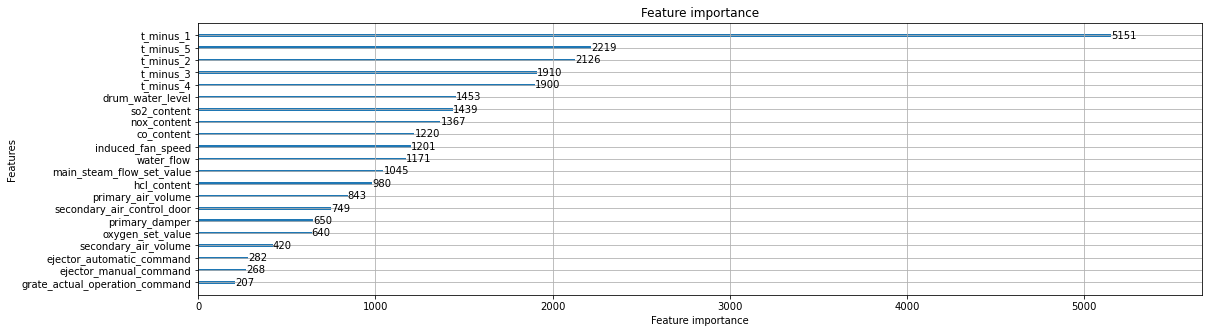

In [334]:
lgb.plot_importance(lgbmRegressor, figsize=(18, 5))

## 03 - modeling - nn

### 3.1 create NN model

In [259]:
MAX_EPOCHS = 500
patience = 3


# init model
model = Sequential([
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1)
])

# define early stoping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')

# compile model
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=[keras.metrics.MeanAbsoluteError()])

model

### 3.2 train NN model

In [260]:
# call fit function to train model
model.fit(x=x_train,
          y=y_train,
          epochs=MAX_EPOCHS,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping])

Epoch 1/500
7819/7819 [==============================] - 11s 1ms/step - loss: 105.8557 - mean_absolute_error: 3.2490 - val_loss: 1.2549 - val_mean_absolute_error: 0.6838
Epoch 2/500
7819/7819 [==============================] - 10s 1ms/step - loss: 1.0472 - mean_absolute_error: 0.8142 - val_loss: 2.6632 - val_mean_absolute_error: 0.8548
Epoch 3/500
7819/7819 [==============================] - 10s 1ms/step - loss: 0.9934 - mean_absolute_error: 0.7937 - val_loss: 3.8525 - val_mean_absolute_error: 1.2877
Epoch 4/500
7819/7819 [==============================] - 10s 1ms/step - loss: 0.9469 - mean_absolute_error: 0.7731 - val_loss: 3.0011 - val_mean_absolute_error: 1.0831


### Evaluate prediction

In [261]:
%%time
lgbm_predictions = lgbmRegressor.predict(x_test)
lgbm_predictions

CPU times: user 214 ms, sys: 2.77 ms, total: 216 ms
Wall time: 38.7 ms


array([61.56527599, 61.67062641, 61.66012265, ..., 57.77747715,
       57.79184676, 57.77451697])

In [262]:
%%time
nn_predictions = model.predict(x_test)
# reshape nn prediction
if len(nn_predictions.shape) == 2:
    nn_predictions = nn_predictions.reshape(nn_predictions.shape[0])
nn_predictions

225/225 [==============================] - 0s 707us/step
CPU times: user 1.22 s, sys: 70.2 ms, total: 1.29 s
Wall time: 311 ms


array([61.33289 , 61.42308 , 61.41868 , ..., 56.909676, 56.92438 ,
       56.93184 ], dtype=float32)

<AxesSubplot:xlabel='datetime'>

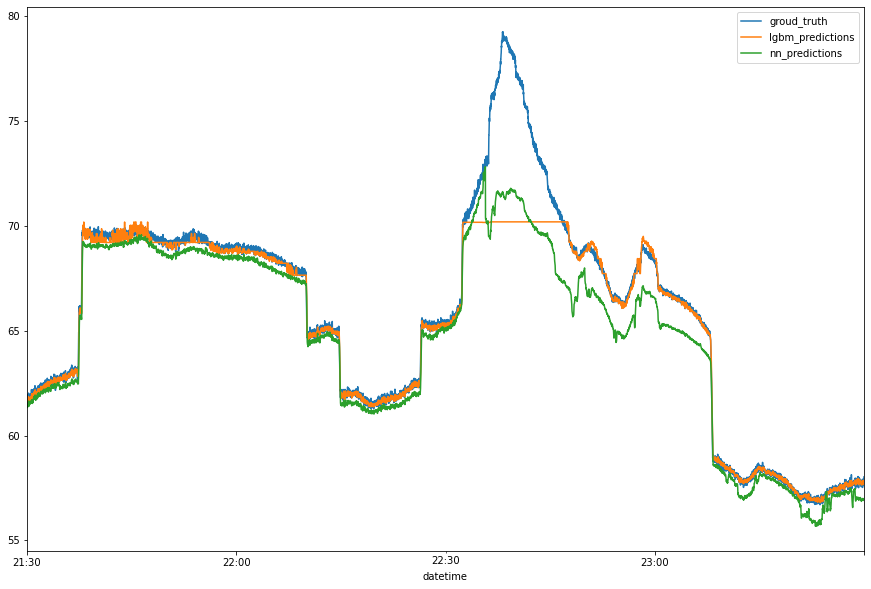

In [263]:
# append predictions with ground truth
val_df = pd.DataFrame(data={'datetime': training.iloc[-val_num:]['datetime'],
                            'water_flow': training.iloc[-val_num:]['water_flow'],
                            'groud_truth': training.iloc[-val_num:]['main_steam_flow'],
                            'lgbm_predictions': lgbm_predictions,
                            'nn_predictions': nn_predictions
                           })

val_df.index = pd.to_datetime(val_df['datetime'], format='%Y-%m-%d %X')

val_df['avg_predictions'] = (val_df['lgbm_predictions'] + val_df['nn_predictions']) / 2

# plot ground truth vs predictions
val_df[['groud_truth', 'lgbm_predictions', 'nn_predictions']].plot.line(figsize=(15, 10))

<AxesSubplot:xlabel='datetime'>

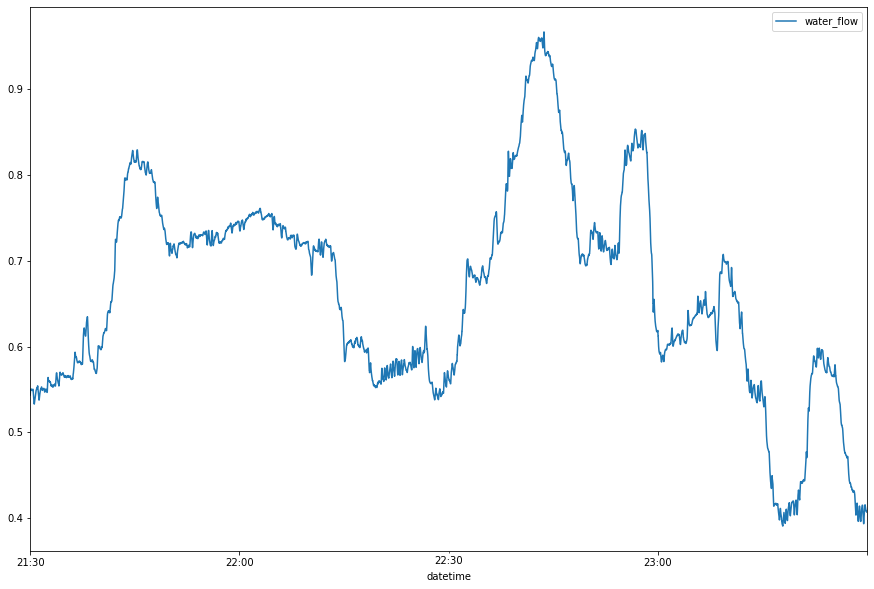

In [264]:
# plot ground truth vs predictions
val_df[['water_flow']].plot.line(figsize=(15, 10))

### batch prediction

In [265]:
# retrieve test_x
# test_x = testing[numerical_features + categorical_columns_onehot]
test_x = testing[numerical_features + time_series_features]
y_test_pred_lgbm = lgbmRegressor.predict(test_x)
y_test_pred_nn = model.predict(test_x)

57/57 [==============================] - 0s 759us/step


In [266]:
# reshape
if len(y_test_pred_nn.shape):
    y_test_pred_nn = y_test_pred_nn.reshape(1800)


# generate submission file
submission_file = pd.DataFrame(data={'ID':[i for i in range(1, 1801)], 
                                     'Time':testing['datetime'].values, 
                                     'Steam_flow_nn':y_test_pred_nn, 
                                     'Steam_flow_lgbm':y_test_pred_lgbm,
                                     'Water_flow':testing['water_flow'].values})
submission_file.head()

ID                 Time  Steam_flow_nn  Steam_flow_lgbm  Water_flow
0   1  2021-12-22 23:30:00      57.001991        57.871072    0.407695
1   2  2021-12-22 23:30:01      39.705982        54.942694    0.407922
2   3  2021-12-22 23:30:02      26.160715        50.659409    0.407475
3   4  2021-12-22 23:30:03      -0.898270        47.464818    0.407130
4   5  2021-12-22 23:30:04     -24.313913        45.539429    0.406939

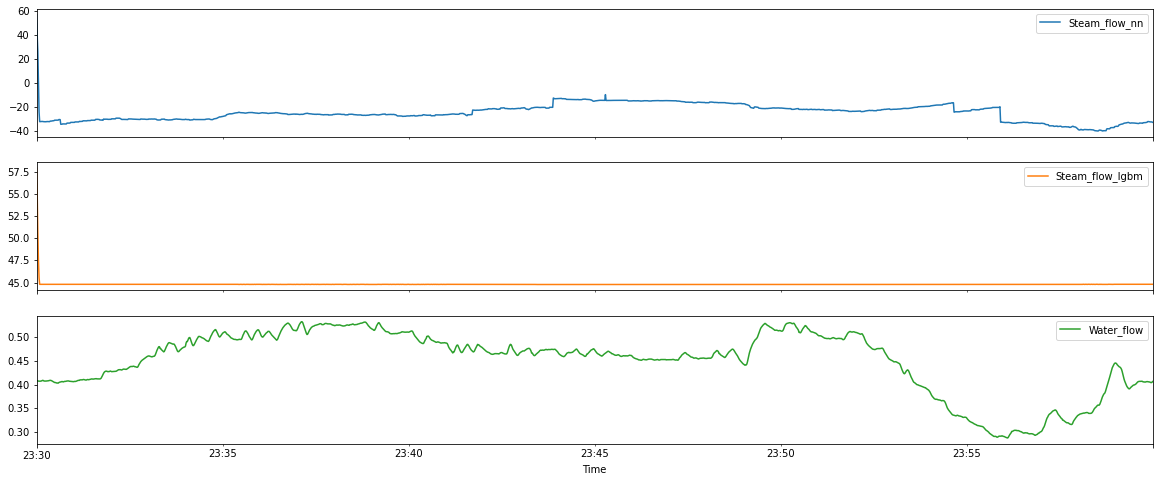

In [267]:
# plot predictions
date_time = pd.to_datetime(submission_file['Time'], format='%Y-%m-%d %H:%M:%S')
plot_cols = ['Steam_flow_nn', 'Steam_flow_lgbm', 'Water_flow']
plot_features = submission_file[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(20, 8))

In [268]:
submission_file['Steam_flow_avg'] = (submission_file['Steam_flow_nn'] + submission_file['Steam_flow_lgbm']) / 2

In [269]:
submission_file.head()

ID                 Time  Steam_flow_nn  Steam_flow_lgbm  Water_flow  \
0   1  2021-12-22 23:30:00      57.001991        57.871072    0.407695   
1   2  2021-12-22 23:30:01      39.705982        54.942694    0.407922   
2   3  2021-12-22 23:30:02      26.160715        50.659409    0.407475   
3   4  2021-12-22 23:30:03      -0.898270        47.464818    0.407130   
4   5  2021-12-22 23:30:04     -24.313913        45.539429    0.406939   

   Steam_flow_avg  
0       57.436532  
1       47.324338  
2       38.410062  
3       23.283274  
4       10.612758

In [270]:
# rename columns
submission_file.rename(columns={'Steam_flow_avg':'Steam_flow'}, inplace=True)

# define output columns
output_columns = ['ID','Time', 'Steam_flow']

# write to local disk
submission_file[output_columns].to_csv('../submission_lgbm_nn_avg.csv', index=False)

In [271]:
submission_file[output_columns].head()

ID                 Time  Steam_flow
0   1  2021-12-22 23:30:00   57.436532
1   2  2021-12-22 23:30:01   47.324338
2   3  2021-12-22 23:30:02   38.410062
3   4  2021-12-22 23:30:03   23.283274
4   5  2021-12-22 23:30:04   10.612758

### loop prediction

In [335]:
# init varaiables
pred = 0
y_pred = []
for i in range(testing.shape[0]):

    # retrieve features
    t = testing.iloc[i][numerical_features + time_series_features]
    # fill up t minus 1 if not first data point
    if i != 0:
        if i < look_back:
            s_idx = 0
            e_idx = i
        else:
            s_idx = i - look_back
            e_idx = i
        # retrieve prev step prediction by idx
        pre_preds = y_pred[s_idx:e_idx]
        # log
        print(f"start_idx:{s_idx}, end_idx:{e_idx}, y_pred_length:{len(y_pred)}, y_pred:{y_pred}, pre_pred:{pre_preds}")
        print(t)
        for idx, p in enumerate(pre_preds[::-1]):
            t[f't_minus_{idx+1}'] = (p - main_steam_min) / (main_steam_max - main_steam_min)
        print(t)
    # transform data
    # x = scaler.transform(t[numerical_features].values.reshape(-1, len(numerical_features)))
    # reshape features
    features = t.values.reshape(-1, len(numerical_features + time_series_features))
    # make prediction using lgbm
    pred = lgbmRegressor.predict(features)
    # make prediction using NN
    # pred = model.predict(x)
    # log
    print(f"At step {i} predicted value is {pred}")
    # append to array
    y_pred.append(pred[0])
    
y_pred

At step 0 predicted value is [57.88497605]
start_idx:0, end_idx:1, y_pred_length:1, y_pred:[57.88497604672923], pre_pred:[57.88497604672923]
oxygen_set_value                  0.329531
primary_air_volume                0.523623
main_steam_flow_set_value         0.633463
ejector_manual_command            0.142857
ejector_automatic_command         0.499998
nox_content                       0.797569
grate_actual_operation_command    0.285716
secondary_air_control_door        0.495084
hcl_content                       0.041877
secondary_air_volume              0.516133
water_flow                        0.407922
so2_content                       0.011421
drum_water_level                  0.473577
induced_fan_speed                 0.506663
co_content                        0.009908
primary_damper                    0.540557
t_minus_1                        -1.185532
t_minus_2                         0.421756
t_minus_3                         0.414026
t_minus_4                         0.414818

start_idx:72, end_idx:77, y_pred_length:77, y_pred:[57.88497604672923, 57.89860712953729, 57.91608347828408, 57.90801894471494, 57.89465136233239, 57.89234305357521, 57.89743971339005, 57.89732131232689, 57.89743971339005, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.898786074625626, 57.898786074625626, 57.898167909112075, 57.89828631017524, 57.89828631017524, 57.89828631017524, 57.898167909112075, 57.898167909112075, 57.89809712262527, 57.897921032854306, 57.89765353590403, 57.89765353590403, 57.89982252588818, 57.89982252588818, 57.89946840721688, 57.89982252588818, 57.89982252588818, 57.89946840721688, 57.899243426053275, 57.899243426053275, 57.89888930738197, 57.899243426053275, 57.89888930738197, 

Name: 143, dtype: object
At step 143 predicted value is [57.90047089]
start_idx:139, end_idx:144, y_pred_length:144, y_pred:[57.88497604672923, 57.89860712953729, 57.91608347828408, 57.90801894471494, 57.89465136233239, 57.89234305357521, 57.89743971339005, 57.89732131232689, 57.89743971339005, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.898786074625626, 57.898786074625626, 57.898167909112075, 57.89828631017524, 57.89828631017524, 57.89828631017524, 57.898167909112075, 57.898167909112075, 57.89809712262527, 57.897921032854306, 57.89765353590403, 57.89765353590403, 57.89982252588818, 57.89982252588818, 57.89946840721688, 57.89982252588818, 57.89982252588818, 57.89946840721688, 57.899243426053275, 57.89

Name: 214, dtype: object
oxygen_set_value                  0.329531
primary_air_volume                  0.5916
main_steam_flow_set_value         0.633463
ejector_manual_command            0.142857
ejector_automatic_command         0.499998
nox_content                        0.42334
grate_actual_operation_command     0.14286
secondary_air_control_door        0.495747
hcl_content                       0.041396
secondary_air_volume              0.516133
water_flow                        0.487432
so2_content                       0.021568
drum_water_level                  0.361396
induced_fan_speed                 0.551991
co_content                        0.007159
primary_damper                    0.607633
t_minus_1                         0.418347
t_minus_2                         0.418347
t_minus_3                         0.418347
t_minus_4                         0.418358
t_minus_5                         0.418377
Name: 214, dtype: object
At step 214 predicted value is [57.89940302]
st

start_idx:280, end_idx:285, y_pred_length:285, y_pred:[57.88497604672923, 57.89860712953729, 57.91608347828408, 57.90801894471494, 57.89465136233239, 57.89234305357521, 57.89743971339005, 57.89732131232689, 57.89743971339005, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.898786074625626, 57.898786074625626, 57.898167909112075, 57.89828631017524, 57.89828631017524, 57.89828631017524, 57.898167909112075, 57.898167909112075, 57.89809712262527, 57.897921032854306, 57.89765353590403, 57.89765353590403, 57.89982252588818, 57.89982252588818, 57.89946840721688, 57.89982252588818, 57.89982252588818, 57.89946840721688, 57.899243426053275, 57.899243426053275, 57.89888930738197, 57.899243426053275, 57.8988893073819

At step 350 predicted value is [57.86224048]
start_idx:346, end_idx:351, y_pred_length:351, y_pred:[57.88497604672923, 57.89860712953729, 57.91608347828408, 57.90801894471494, 57.89465136233239, 57.89234305357521, 57.89743971339005, 57.89732131232689, 57.89743971339005, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.89820697479072, 57.8979917555627, 57.8979917555627, 57.89820697479072, 57.898786074625626, 57.898786074625626, 57.898167909112075, 57.89828631017524, 57.89828631017524, 57.89828631017524, 57.898167909112075, 57.898167909112075, 57.89809712262527, 57.897921032854306, 57.89765353590403, 57.89765353590403, 57.89982252588818, 57.89982252588818, 57.89946840721688, 57.89982252588818, 57.89982252588818, 57.89946840721688, 57.899243426053275, 57.899243426053275, 57.8988893

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




oxygen_set_value                  0.329531
primary_air_volume                0.795225
main_steam_flow_set_value         0.633463
ejector_manual_command            0.571427
ejector_automatic_command         0.499998
nox_content                       0.613938
grate_actual_operation_command     0.57143
secondary_air_control_door        0.001585
hcl_content                       0.037457
secondary_air_volume                   0.0
water_flow                        0.496055
so2_content                       0.014641
drum_water_level                  0.433454
induced_fan_speed                 0.732538
co_content                        0.008915
primary_damper                    0.876093
t_minus_1                        -1.185532
t_minus_2                        -1.185532
t_minus_3                        -1.185532
t_minus_4                        -1.185532
t_minus_5                        -1.185532
Name: 1276, dtype: object
oxygen_set_value                  0.329531
primary_air_volume         

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[57.88497604672923,
 57.89860712953729,
 57.91608347828408,
 57.90801894471494,
 57.89465136233239,
 57.89234305357521,
 57.89743971339005,
 57.89732131232689,
 57.89743971339005,
 57.89820697479072,
 57.8979917555627,
 57.8979917555627,
 57.8979917555627,
 57.89820697479072,
 57.89820697479072,
 57.8979917555627,
 57.8979917555627,
 57.8979917555627,
 57.8979917555627,
 57.89820697479072,
 57.8979917555627,
 57.8979917555627,
 57.89820697479072,
 57.89820697479072,
 57.8979917555627,
 57.8979917555627,
 57.89820697479072,
 57.898786074625626,
 57.898786074625626,
 57.898167909112075,
 57.89828631017524,
 57.89828631017524,
 57.89828631017524,
 57.898167909112075,
 57.898167909112075,
 57.89809712262527,
 57.897921032854306,
 57.89765353590403,
 57.89765353590403,
 57.89982252588818,
 57.89982252588818,
 57.89946840721688,
 57.89982252588818,
 57.89982252588818,
 57.89946840721688,
 57.899243426053275,
 57.899243426053275,
 57.89888930738197,
 57.899243426053275,
 57.89888930738197,
 5

In [336]:
# generate submission file
submission_file = pd.DataFrame(data={'ID':[i for i in range(1, 1801)], 
                                     'Time':testing['datetime'].values, 
                                     # 'Steam_flow_nn':y_pred, 
                                     'Steam_flow_lgbm':y_pred,
                                     'Water_flow':testing['water_flow'].values})
submission_file.head()

ID                 Time  Steam_flow_lgbm  Water_flow
0   1  2021-12-22 23:30:00        57.884976    0.407695
1   2  2021-12-22 23:30:01        57.898607    0.407922
2   3  2021-12-22 23:30:02        57.916083    0.407475
3   4  2021-12-22 23:30:03        57.908019    0.407130
4   5  2021-12-22 23:30:04        57.894651    0.406939

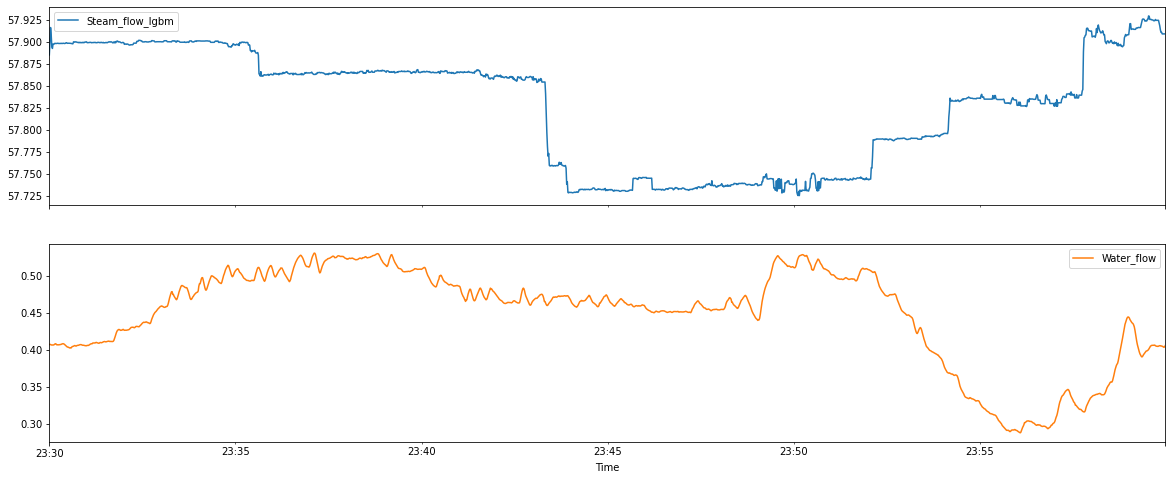

In [337]:
# plot predictions
date_time = pd.to_datetime(submission_file['Time'], format='%Y-%m-%d %H:%M:%S')
plot_cols = ['Steam_flow_lgbm', 'Water_flow']
plot_features = submission_file[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(20, 8))